#  Lasso Regresyon: 4 Farklı Senaryo Analizi (R² ve MAE ile)

Lasso (Least Absolute Shrinkage and Selection Operator), gereksiz özelliklerin katsayılarını sıfıra indirerek modelden çıkaran güçlü bir algoritmadır. Ancak, verilerin ölçeğine (Scale) çok duyarlıdır.

Bu çalışmada 4 farklı senaryoyu test edeceğiz:
1.  **Saf Hali:** Ölçekleme ve özellik seçimi yok (Lasso için riskli, performans düşük beklenebilir).
2.  **Standard:** Ölçekleme (`StandardScaler`) ve Threshold (`VarianceThreshold`) var.
3.  **Sadece Kümeleme:** k-NN ile üretilen segment bilgisi var, ancak Lasso için ölçekleme yok.
4.  **Full Paket (Hibrit):** Ölçekleme, Threshold ve Kümeleme (Segmentasyon) hepsi bir arada.

**Metrikler:**
* **R²:** Başarı oranı (Yüksek iyidir).
* **MAE:** Ortalama Hata (Düşük iyidir).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import r2_score, mean_absolute_error

# Lasso, ölçeklenmemiş veride uyarı verebilir, bunları gizliyoruz
import warnings
warnings.filterwarnings('ignore')

### 1. Veri Yükleme ve Temizleme
Veri setini yüklüyor, para birimi ve virgül hatalarını temizliyor, hedef değişkeni (`price`) ayırıyoruz.

In [3]:
# Veriyi yükle
df = pd.read_csv('ekip_odevi_ham_veri_30k.csv')

# Temizleme Fonksiyonları
def clean_currency(x):
    try:
        if isinstance(x, str):
            x = x.replace('£', '').replace(',', '').strip()
            return float(x) if x and x.lower() != 'nan' else np.nan
        return float(x)
    except: return np.nan

def clean_number(x):
    try:
        if isinstance(x, str):
            x = x.replace(',', '').strip()
            return float(x) if x and x.lower() not in ['unknown', 'nan', ''] else np.nan
        return float(x)
    except: return np.nan

# Temizliği uygula
df['price_clean'] = df['price'].apply(clean_currency)
df['mileage_clean'] = df['mileage'].apply(clean_number)

# Sütun seçimi
features_raw = ['year', 'price_clean', 'mileage_clean', 'mpg', 'engineSize', 'marka', 'transmission', 'fuelType']
df_clean = df[features_raw].dropna().reset_index(drop=True)

# Hedef ve Özellikler
X = df_clean.drop(['price_clean'], axis=1)
y = df_clean['price_clean']

# Eğitim ve Test Ayrımı
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sütun Grupları
categorical_cols = ['marka', 'transmission', 'fuelType']
numerical_cols = ['year', 'mileage_clean', 'mpg', 'engineSize']

print("Veri temizlendi ve ayrıldı.")

Veri temizlendi ve ayrıldı.


### 2. Hazırlık: Kümeleme (k-NN) ile Veri Zenginleştirme
Senaryo 3 ve 4 için gerekli olan "Segment" bilgisini burada üretiyoruz.
* Önce eğitim setindeki fiyatları "Ekonomik, Orta, Lüks" olarak etiketliyoruz.
* k-NN algoritmasını eğitip, araçların fiziksel özelliklerine göre hangi segmente girdiğini tahmin ettiriyoruz.
* Bu tahminleri `Segment` adında yeni bir sütun olarak veriye ekliyoruz.

In [4]:
# A) Hedef Segmentleri Oluştur (Sadece Eğitim Seti Üzerinde)
y_train_segments = pd.qcut(y_train, q=3, labels=['Ekonomik', 'Orta', 'Lüks'])

# B) k-NN Modelini Kur (k-NN için Scaling ZORUNLUDUR)
knn_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

knn_model = Pipeline(steps=[
    ('preprocessor', knn_preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=15))
])

knn_model.fit(X_train, y_train_segments)

# C) Yeni Segment Özelliğini Tahmin Et
train_seg_pred = knn_model.predict(X_train)
test_seg_pred = knn_model.predict(X_test)

# D) Zenginleştirilmiş Veri Setlerini Oluştur
X_train_aug = X_train.copy()
X_test_aug = X_test.copy()
X_train_aug['Segment'] = train_seg_pred
X_test_aug['Segment'] = test_seg_pred

# Yeni kategorik sütun listesi
categorical_cols_aug = categorical_cols + ['Segment']

print("Segmentasyon tamamlandı. Veriye 'Segment' sütunu eklendi.")

Segmentasyon tamamlandı. Veriye 'Segment' sütunu eklendi.


### Senaryo 1: Lasso (Saf Hali)
* **Durum:** Veri ölçeklenmemiştir (No Scaling).
* **Beklenti:** Lasso, ölçeklenmemiş veride büyük sayısal değerlere (örn: mileage) aşırı tepki verip yanlış özellik elemesi yapabilir. Performansın düşük olması veya modelin zorlanması beklenir.

In [5]:
preprocessor_1 = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols), # Scaling YOK
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

model_1 = Pipeline(steps=[
    ('preprocessor', preprocessor_1),
    ('regressor', Lasso(alpha=1.0, random_state=42))
])

model_1.fit(X_train, y_train)
y_pred_1 = model_1.predict(X_test)

r2_1 = r2_score(y_test, y_pred_1)
mae_1 = mean_absolute_error(y_test, y_pred_1)

print(f"Senaryo 1 -> R2: {r2_1:.4f} | MAE: {mae_1:.0f} £")

Senaryo 1 -> R2: 0.7727 | MAE: 2991 £


### Senaryo 2: Lasso + Scaling + Threshold
* **Durum:** Veri `StandardScaler` ile standartlaştırılmış ve `VarianceThreshold` ile gereksiz özelliklerden arındırılmıştır.
* **Beklenti:** Bu, Lasso'nun ideal kullanım şeklidir. Dengeli bir performans beklenir.

In [6]:
preprocessor_2 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols), # Scaling VAR
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

model_2 = Pipeline(steps=[
    ('preprocessor', preprocessor_2),
    ('selector', VarianceThreshold(threshold=0.01)), # Threshold VAR
    ('regressor', Lasso(alpha=1.0, random_state=42))
])

model_2.fit(X_train, y_train)
y_pred_2 = model_2.predict(X_test)

r2_2 = r2_score(y_test, y_pred_2)
mae_2 = mean_absolute_error(y_test, y_pred_2)

print(f"Senaryo 2 -> R2: {r2_2:.4f} | MAE: {mae_2:.0f} £")

Senaryo 2 -> R2: 0.7727 | MAE: 2991 £


### Senaryo 3: Lasso + Sadece Kümeleme
* **Durum:** Veriye "Segment" bilgisi eklenmiştir ancak Lasso aşamasında ölçekleme (scaling) yapılmamıştır.
* **Beklenti:** Segment bilgisi faydalı olsa da, Lasso'nun ölçekleme hassasiyeti yüzünden performans tam potansiyeline ulaşamayabilir.

In [7]:
preprocessor_3 = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols), # Scaling YOK
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_aug) # Segment sütunu dahil
    ])

model_3 = Pipeline(steps=[
    ('preprocessor', preprocessor_3),
    ('regressor', Lasso(alpha=1.0, random_state=42))
])

model_3.fit(X_train_aug, y_train)
y_pred_3 = model_3.predict(X_test_aug)

r2_3 = r2_score(y_test, y_pred_3)
mae_3 = mean_absolute_error(y_test, y_pred_3)

print(f"Senaryo 3 -> R2: {r2_3:.4f} | MAE: {mae_3:.0f} £")

Senaryo 3 -> R2: 0.7816 | MAE: 2856 £


### Senaryo 4: Lasso + Scaling + Threshold + Kümeleme
* **Durum:** Hem veri ölçeklenmiş, hem gereksiz özellikler atılmış hem de segment bilgisi eklenmiştir.
* **Beklenti:** En yüksek R² ve en düşük MAE değerinin bu senaryoda çıkması beklenir.

In [8]:
preprocessor_4 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols), # Scaling VAR
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_aug)
    ])

model_4 = Pipeline(steps=[
    ('preprocessor', preprocessor_4),
    ('selector', VarianceThreshold(threshold=0.01)), # Threshold VAR
    ('regressor', Lasso(alpha=1.0, random_state=42))
])

model_4.fit(X_train_aug, y_train)
y_pred_4 = model_4.predict(X_test_aug)

r2_4 = r2_score(y_test, y_pred_4)
mae_4 = mean_absolute_error(y_test, y_pred_4)

print(f"Senaryo 4 -> R2: {r2_4:.4f} | MAE: {mae_4:.0f} £")

Senaryo 4 -> R2: 0.7816 | MAE: 2856 £


### 3. Sonuçların Karşılaştırılması
Tüm senaryoların R² ve MAE skorlarını karşılaştırıyoruz.
* Grafikte **Mavi Barlar** R² skorunu (Yüksek olması iyi),
* **Kırmızı Çizgi** ise MAE Hatasını (Düşük olması iyi) temsil eder.

           Senaryo  R2 Skoru   MAE (Hata)
0      1) Saf Hali  0.772660  2990.971223
1  2) Scale+Thresh  0.772654  2991.145179
2   3) Sadece Küme  0.781559  2855.634962
3    4) Full Paket  0.781553  2855.745627


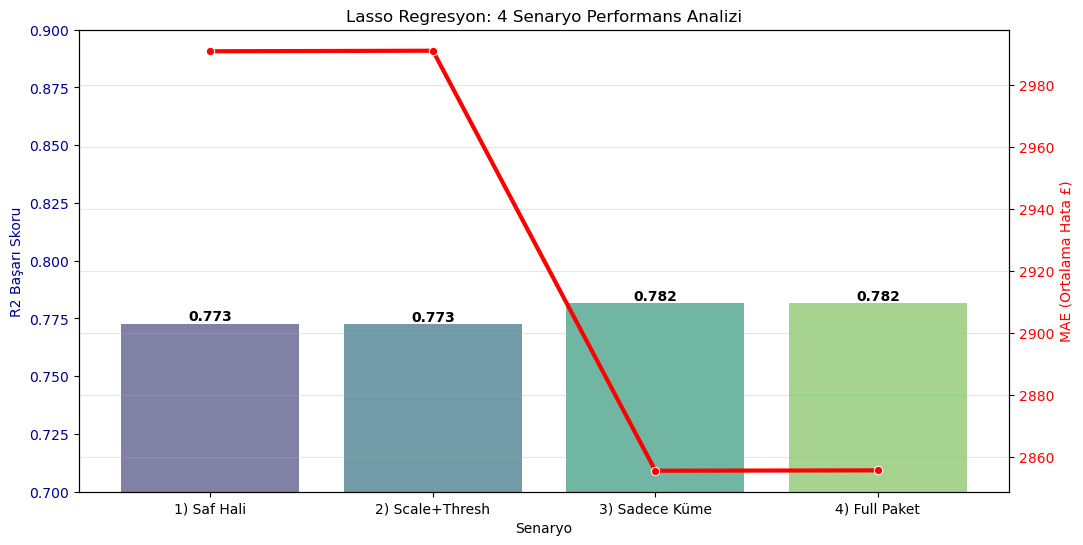

In [9]:
# Sonuç Tablosu
results = pd.DataFrame({
    'Senaryo': ['1) Saf Hali', '2) Scale+Thresh', '3) Sadece Küme', '4) Full Paket'],
    'R2 Skoru': [r2_1, r2_2, r2_3, r2_4],
    'MAE (Hata)': [mae_1, mae_2, mae_3, mae_4]
})

print(results)

# Grafik
fig, ax1 = plt.subplots(figsize=(12, 6))

# R2 Barları
sns.barplot(data=results, x='Senaryo', y='R2 Skoru', ax=ax1, palette='viridis', alpha=0.7)
ax1.set_ylabel('R2 Başarı Skoru', color='darkblue')
ax1.set_ylim(0.70, 0.90) # Farkı görmek için scale ayarı
ax1.tick_params(axis='y', labelcolor='darkblue')

# MAE Çizgisi
ax2 = ax1.twinx()
sns.lineplot(data=results, x='Senaryo', y='MAE (Hata)', ax=ax2, color='red', marker='o', linewidth=3)
ax2.set_ylabel('MAE (Ortalama Hata £)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Değerleri yazdır
for index, row in results.iterrows():
    ax1.text(index, row['R2 Skoru'], f"{row['R2 Skoru']:.3f}", color='black', ha="center", va="bottom", fontweight='bold')

plt.title('Lasso Regresyon: 4 Senaryo Performans Analizi')
plt.grid(True, alpha=0.3)
plt.show()